In [2]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler

# Data Loading

In [3]:
# load data from s3 storage
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,-0.059343,-0.751958,-0.314242,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,-0.059218,-0.298613,0.029315,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,-0.019658,-0.084493,-0.116301,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,0.207732,-0.046667,-0.266864,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.

In [4]:
# we pick responder_6 as the target (same target as the data challenge)
target = "responder_6"
features = [col for col in data.columns if "feature" in col]
X, y = data[features], data[target]

n = X.height
n_train = int(0.8 * n)
X_train_raw = X.slice(0, n_train)
y_train_raw = y.slice(0, n_train)
X_val_raw = X.slice(n_train)
y_val_raw = y.slice(n_train)

# Scaling
scaler_x = StandardScaler()
scaler_y = StandardScaler()

# We use .to_numpy() for the scalers
x_train_np = scaler_x.fit_transform(X_train_raw.to_numpy())
# Important: y must be 2D for the scaler
y_train_np = scaler_y.fit_transform(y_train_raw.to_numpy().reshape(-1, 1))

x_val_np = scaler_x.transform(X_val_raw.to_numpy())
y_val_np = scaler_y.transform(y_val_raw.to_numpy().reshape(-1, 1))

# Dataset Class
class TimeSeriesDataset(Dataset):
    def __init__(self, X_np, y_np):
        # We store them as tensors directly to avoid re-converting at each __getitem__
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiation
train_dataset = TimeSeriesDataset(x_train_np, y_train_np)
val_dataset = TimeSeriesDataset(x_val_np, y_val_np)

# Loader
train_data_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

# Model Evaluation

  5%|▌         | 1/20 [00:08<02:32,  8.05s/it]

Epoch 01 | loss=162.603 | R2_rec_train=0.2355 | R2_rec_val=0.1596 | R2_sup_train=0.7970 | R2_sup_val=0.7864


 10%|█         | 2/20 [00:16<02:25,  8.09s/it]

Epoch 02 | loss=137.674 | R2_rec_train=0.3701 | R2_rec_val=0.2057 | R2_sup_train=0.8264 | R2_sup_val=0.8224


 15%|█▌        | 3/20 [00:24<02:17,  8.12s/it]

Epoch 03 | loss=132.960 | R2_rec_train=0.4218 | R2_rec_val=0.2816 | R2_sup_train=0.8293 | R2_sup_val=0.8377


 20%|██        | 4/20 [00:33<02:13,  8.37s/it]

Epoch 04 | loss=130.820 | R2_rec_train=0.4515 | R2_rec_val=0.2786 | R2_sup_train=0.8300 | R2_sup_val=0.8409


 25%|██▌       | 5/20 [00:40<01:57,  7.86s/it]

Epoch 05 | loss=129.436 | R2_rec_train=0.4646 | R2_rec_val=0.3117 | R2_sup_train=0.8310 | R2_sup_val=0.8416


 30%|███       | 6/20 [00:47<01:46,  7.61s/it]

Epoch 06 | loss=130.649 | R2_rec_train=0.4375 | R2_rec_val=0.3110 | R2_sup_train=0.8317 | R2_sup_val=0.8446


 35%|███▌      | 7/20 [00:54<01:38,  7.58s/it]

Epoch 07 | loss=128.804 | R2_rec_train=0.4655 | R2_rec_val=0.3177 | R2_sup_train=0.8321 | R2_sup_val=0.8444


 40%|████      | 8/20 [01:01<01:28,  7.40s/it]

Epoch 08 | loss=127.049 | R2_rec_train=0.4881 | R2_rec_val=0.3325 | R2_sup_train=0.8327 | R2_sup_val=0.8431


 45%|████▌     | 9/20 [01:08<01:20,  7.28s/it]

Epoch 09 | loss=126.123 | R2_rec_train=0.5000 | R2_rec_val=0.3266 | R2_sup_train=0.8333 | R2_sup_val=0.8446


 50%|█████     | 10/20 [01:16<01:14,  7.44s/it]

Epoch 10 | loss=127.159 | R2_rec_train=0.4796 | R2_rec_val=0.3891 | R2_sup_train=0.8336 | R2_sup_val=0.8441


 55%|█████▌    | 11/20 [01:23<01:06,  7.36s/it]

Epoch 11 | loss=126.130 | R2_rec_train=0.4979 | R2_rec_val=0.3508 | R2_sup_train=0.8335 | R2_sup_val=0.8443


 60%|██████    | 12/20 [01:31<00:59,  7.47s/it]

Epoch 12 | loss=125.744 | R2_rec_train=0.4996 | R2_rec_val=0.3589 | R2_sup_train=0.8340 | R2_sup_val=0.8427


 65%|██████▌   | 13/20 [01:39<00:52,  7.56s/it]

Epoch 13 | loss=125.921 | R2_rec_train=0.4943 | R2_rec_val=0.3791 | R2_sup_train=0.8341 | R2_sup_val=0.8463


 70%|███████   | 14/20 [01:46<00:44,  7.38s/it]

Epoch 14 | loss=125.138 | R2_rec_train=0.5063 | R2_rec_val=0.3767 | R2_sup_train=0.8345 | R2_sup_val=0.8461


 75%|███████▌  | 15/20 [01:53<00:36,  7.31s/it]

Epoch 15 | loss=124.605 | R2_rec_train=0.5115 | R2_rec_val=0.3390 | R2_sup_train=0.8348 | R2_sup_val=0.8428


 80%|████████  | 16/20 [02:00<00:29,  7.37s/it]

Epoch 16 | loss=124.760 | R2_rec_train=0.5103 | R2_rec_val=0.3478 | R2_sup_train=0.8346 | R2_sup_val=0.8405


 85%|████████▌ | 17/20 [02:07<00:21,  7.29s/it]

Epoch 17 | loss=124.362 | R2_rec_train=0.5145 | R2_rec_val=-0.3970 | R2_sup_train=0.8351 | R2_sup_val=0.8473


 90%|█████████ | 18/20 [02:14<00:14,  7.18s/it]

Epoch 18 | loss=129.748 | R2_rec_train=0.4255 | R2_rec_val=0.3331 | R2_sup_train=0.8345 | R2_sup_val=0.8444


 95%|█████████▌| 19/20 [02:22<00:07,  7.42s/it]

Epoch 19 | loss=124.663 | R2_rec_train=0.5036 | R2_rec_val=0.3229 | R2_sup_train=0.8355 | R2_sup_val=0.8477


100%|██████████| 20/20 [02:30<00:00,  7.51s/it]

Epoch 20 | loss=123.968 | R2_rec_train=0.5139 | R2_rec_val=0.3713 | R2_sup_train=0.8355 | R2_sup_val=0.8464


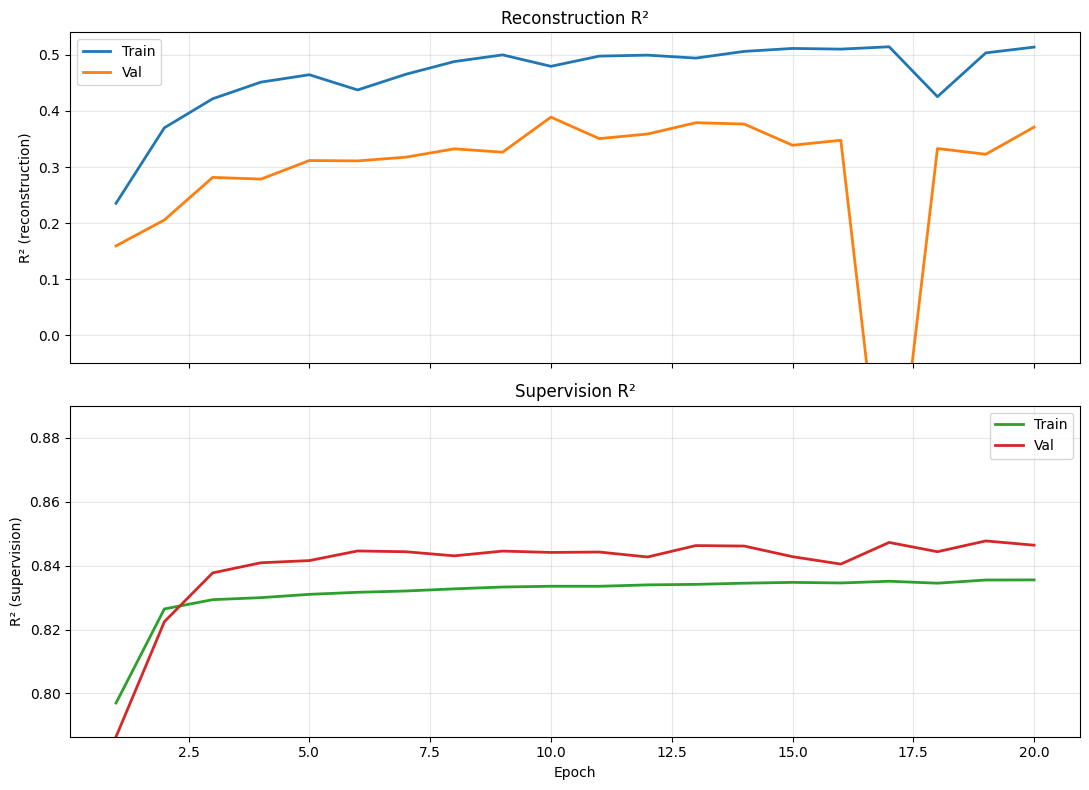

In [5]:
# define model
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]
activation = torch.nn.LeakyReLU

model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
    activation=activation
)

# define optimization parameters
lr = 0.5e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 0.1
beta = 1.0

optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

train = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)

# Extract latent representation

In [5]:
def extract_latent_features(model, data_loader, device):
    """
    Passes data through the encoder to get the latent representation Z.
    """
    model.eval()  
    latent_space = []
    
    with torch.no_grad():
        for batch_x, _ in data_loader:
            batch_x = batch_x.to(device)
            z, _, _ = model(batch_x)
            latent_space.append(z.cpu()) 
            
    return torch.cat(latent_space, dim=0)

# --- Execution ---
z_train = extract_latent_features(model, train_data_loader, device)
z_val = extract_latent_features(model, val_data_loader, device)

print(f"Latent Train shape: {z_train.shape}") # Should be (n_train, 16)
print(f"Latent Val shape: {z_val.shape}")     # Should be (n_val, 16)

import polars as pl

def latent_to_polars(z_tensor, prefix="latent_"):
    """
    Converts a latent tensor to a Polars DataFrame with named columns.
    """
    z_np = z_tensor.detach().cpu().numpy()
    
    n_latent = z_np.shape[1]
    col_names = [f"{prefix}{i}" for i in range(n_latent)]
    
    return pl.DataFrame(z_np, schema=col_names)

# --- Execution ---
df_z_train = latent_to_polars(z_train)
df_z_val = latent_to_polars(z_val)

print(f"Train Latent Head:\n{df_z_train.head(3)}")

Latent Train shape: torch.Size([1189975, 16])
Latent Val shape: torch.Size([297494, 16])
Train Latent Head:
shape: (3, 16)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ latent_0  ┆ latent_1  ┆ latent_2  ┆ latent_3 ┆ … ┆ latent_12 ┆ latent_13 ┆ latent_14 ┆ latent_15 │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f32       ┆ f32       ┆ f32       ┆ f32      ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -2.725097 ┆ -1.376759 ┆ -2.313703 ┆ 8.171041 ┆ … ┆ -5.405897 ┆ 1.288681  ┆ -1.307635 ┆ 0.568643  │
│ -1.641407 ┆ -0.198344 ┆ -0.392415 ┆ 3.885031 ┆ … ┆ -3.678998 ┆ -0.347022 ┆ -1.219181 ┆ 0.179343  │
│ 0.150232  ┆ 1.137359  ┆ -0.251691 ┆ 1.298089 ┆ … ┆ 1.474927  ┆ 0.241983  ┆ -0.60438  ┆ -0.462806 │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴─────

In [6]:
# save datasets
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/latent_X_train.parquet"
reader.save_parquet(df_z_train, FILE_KEY_S3)

BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/latent_X_val.parquet"
reader.save_parquet(df_z_val, FILE_KEY_S3)